# Takeda 
## Data Challenge
*************************

### Introduction

The importance of Diabetes in our daily lives has been known for nearly 200 years. In this challenge, the goal is
to analyse a dataset of 769 patients, primarily taken from people in India; the gender distribution is 318 male and 350 female patients. Additionally, it can be observed that occurrence of diabetes is independent of gender (with 34% of all male and 35% of all female patients having diabetes).

In the next step, we want to analyze the different measured parameters, and understand their ability to distinguish
Diabetes patients from healthy ones.

### About the dataset

The dataset is found on [kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database/home) under the name Pima Indians Diabetes Database. The following description was directly taken from the website:

"This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on."

### Analysis of parameters

For each of the 769 patients, we are given a set of 12 different parameters. In the first analysis, we want to cluster the individuals with Diabetes Type I and Diabetes Type II. Therefore, a quick summary of the parameters important for this determination is given in the following Table, adapted from [[1]](https://www.diabetes.co.uk/difference-between-type1-and-type2-diabetes.html). 

<!-- How can I center-align the entries of this table? -->

| Diabetes Type I                           | Diabetes Type II                                    |
|-------------------------------------------|-----------------------------------------------------|
| Diagnosis at an early age                 | Diagnosed in people over 30 years old.              |
| BMI is not a factor.                      | Association with being overweight.                  |
| Higher ketone levels (not measured here). | High blood pressure often found.                    | 
| Causes are unknown, partially genetics.   | Complex causes, ranging from lifestyle to genetics. |

Given this Table, it is obvious that the most imporant parameters for distinguishing type I from type II diabetes are the age, the BMI and blood pressure. Those will be used for the first part in the data analysis.


### Clustering and visualisation of individuals with Diabetes Type I and Type II

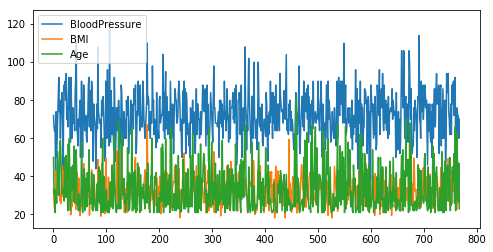

In [8]:
import numpy as np
import pandas as pd
from utils import *

""" 
Cleaning the data
"""

# Read in the dataframe with all it's data
df = pd.read_csv("diabetes.csv")

# Make sure that all relevant numeric data are type 'float'
t1_t2 = df[['BloodPressure', 'BMI', 'Age']].astype('float')

# Clean the data so that unrealistic values are removed.
t1_t2_clean = t1_t2[ (df.BloodPressure > 0)
                    & (df.BMI > 0) ]

# Show a quick overview of the data
plot_overview(t1_t2_clean)

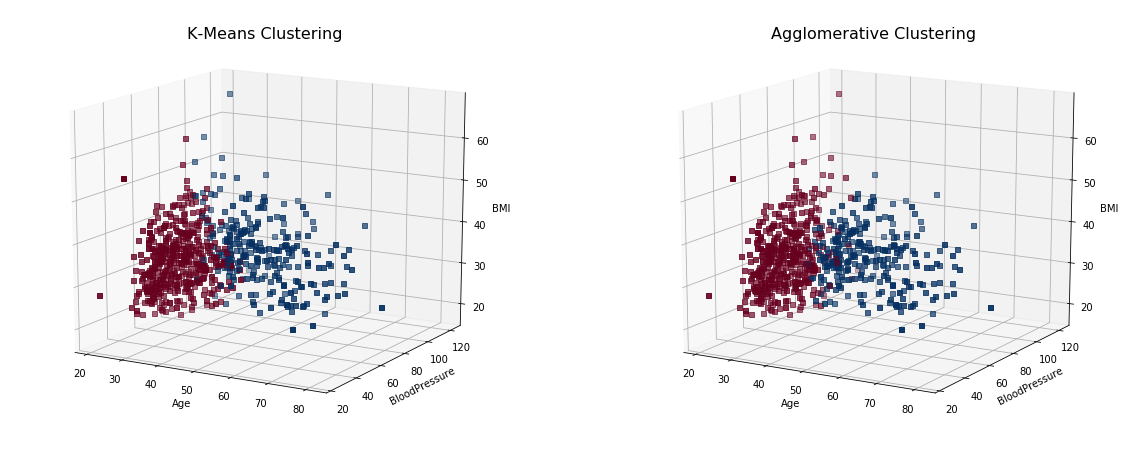

In [2]:
from sklearn.cluster import KMeans, AgglomerativeClustering

"""
Using different clustering algorithms to see which one gives the best result
"""

# Use standard K-Means with two clusters (type I/II) as a first step
kmeans = KMeans(n_clusters=2).fit(t1_t2_clean)

# For comparison, also use Agglomerative Clustering with two clusters (type I/II)
agglo = AgglomerativeClustering(n_clusters=2).fit(t1_t2_clean)

# Visualize the results of both clustering algorithms in 3D
plot_3D(t1_t2_clean, kmeans.labels_, agglo.labels_, "K-Means Clustering", "Agglomerative Clustering")

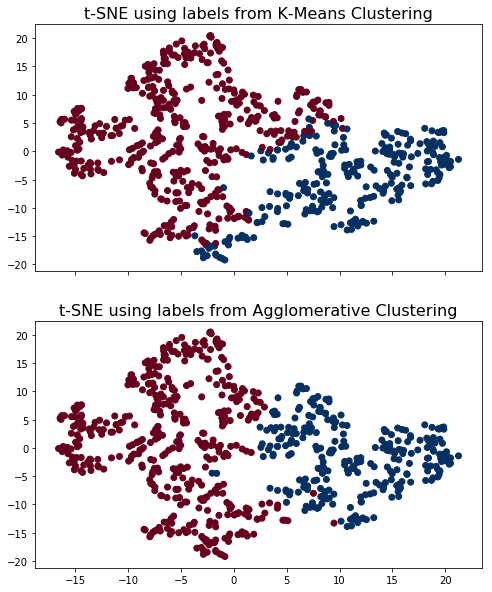

In [3]:
from sklearn.manifold import TSNE

"""
Use dimensionality reduction to visualize the separation of the two clusters
"""

# Perform tSNE on the values with two clusters (type I/II) as a first step
tsne = TSNE(n_components=2, n_iter=300).fit_transform(t1_t2_clean)

plot_TSNE(tsne, kmeans.labels_, agglo.labels_, "K-Means", "Agglomerative")

In [4]:
# PCA DOES NOT MAKE SENSE HERE! POTENTIALLY ON FULL-DIM DATA!

╒══════════╤═════════════════╤══════════╤═══════════╕
│          │ BloodPressure   │ BMI      │ Age       │
╞══════════╪═════════════════╪══════════╪═══════════╡
│ Class I  │ 66 +/- 9        │ 31 +/- 6 │ 26 +/- 5  │
├──────────┼─────────────────┼──────────┼───────────┤
│ Class II │ 82 +/- 10       │ 34 +/- 7 │ 44 +/- 11 │
╘══════════╧═════════════════╧══════════╧═══════════╛


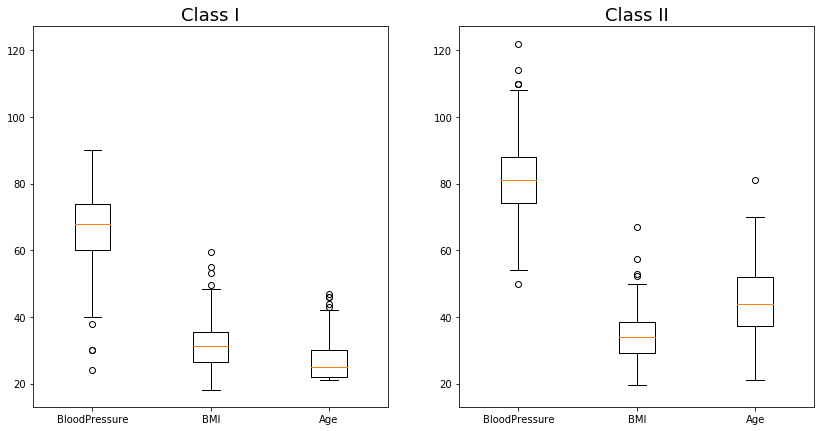

In [5]:
# Find the average BMI, BloodPressure and Age with their STD of each class; output a table
print_tab(t1_t2_clean, kmeans.labels_)

# Visualize the result in a boxplot!
plot_boxplot(t1_t2_clean, kmeans.labels_)

### Summary

Using only the features BloodPressure, BMI and Age, it is possible to visualize the data. Using tSNE on the data leads to a separation of the points in two dimensions; however, it is still not possible to clearly separate the data into certain clusters.

In order to reveal the difference between Diabetes Type I and Type II, the data is clustered with both KMeans and Agglomerative Clustering, using two as the number of clusters. KMeans is further used, as it manages to separate the data better than Agglomerative Clustering.

The boxplots as well as the tables show the differences between the two clusters well. As expected, one of the classes has higher values for the blood pressure, the BMI and the age. This is in accordance to the table above, which shows the major causes for Diabetes Type II. 

Before jumping to quick conclusions, it must be mentioned that the separation of the data into two clusters might have other causes. In order to analyze those potential causes, one could do further analysis with different number of clusters; like that, it is possible to find out the optimal number of clusters. Alternatively, having a dataset with labels for Diabetes Type I and Type II would increase the possibilities for analysis drastically. To concentrate on other aspects of this dataset, I will not cover those approaches here.

--------